### Isolation Forest for Time-Series Anomaly Detection 

In [265]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.fft import fft
from scipy.stats import moment, skew, kurtosis
from statsmodels.tsa.stattools import acf
from scipy.stats import entropy
from sklearn.ensemble import IsolationForest
from sklearn.metrics import accuracy_score, confusion_matrix
import pickle 

#### Data preprocessing

In [266]:
# raw_dt = pd.read_csv("data/realKnownCause/realKnownCause/machine_temperature_system_failure.csv")
raw_dt = pd.read_csv("data/realKnownCause/realKnownCause/nyc_taxi.csv")
# raw_dt = pd.read_csv("data/realTweets/realTweets/Twitter_volume_CRM.csv")
data = raw_dt.copy()
data['timestamp'] = pd.to_datetime(data['timestamp'])
data

,timestamp,value
0,2014-07-01 00:00:00,10844
1,2014-07-01 00:30:00,8127
2,2014-07-01 01:00:00,6210
3,2014-07-01 01:30:00,4656
4,2014-07-01 02:00:00,3820
...,...,...
10315,2015-01-31 21:30:00,24670
10316,2015-01-31 22:00:00,25721
10317,2015-01-31 22:30:00,27309
10318,2015-01-31 23:00:00,26591


Anomalies labeled according to the NAB github (https://github.com/numenta/NAB/blob/master/labels/):

In [267]:
data['anomaly'] = 0 # 1 = anomaly, 0 = normal

# Access the lists
with open('lists.pkl', 'rb') as f:
    lists = pickle.load(f)
#Change according to ds: [0] = machine_temperature, [1] = twitter_volume , [2] = nyc_taxi
instances_of_anomaly_nyc_taxi = lists[2]        

# Marking the instances of anomaly in the dataset
for instance in instances_of_anomaly_nyc_taxi: 
    start = pd.to_datetime(instance[0])
    end = pd.to_datetime(instance[1])
    data.loc[(data['timestamp'] >= start) & (data['timestamp'] <= end), 'anomaly'] = 1

Plot the data with anomalies marked

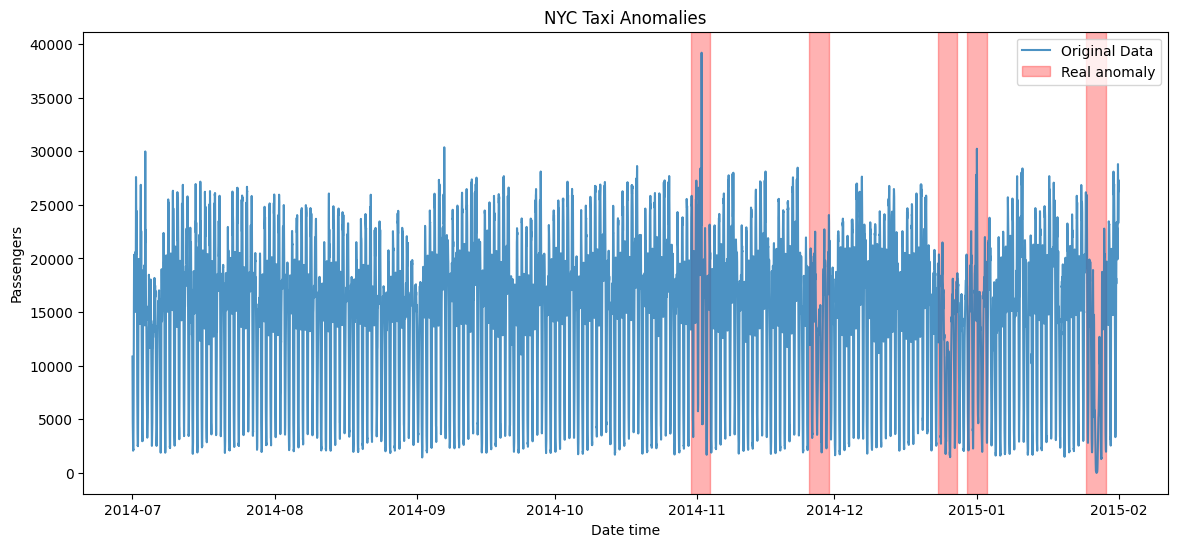

In [268]:
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(data['timestamp'], data['value'], label='Original Data', alpha=0.8)
ax.fill_between(data['timestamp'], 0, 1, where=data['anomaly'], color='red', alpha=0.3, transform=ax.get_xaxis_transform(),label='Real anomaly')
# plt.title('Machine Temperature System Failure')
plt.title('NYC Taxi Anomalies')
plt.xlabel('Date time')
# plt.ylabel('Temperature')
plt.ylabel('Passengers')
plt.legend()
plt.show()

#### Split data into training, validation and testing sets
60% training, 20% validation and 20% testing

In [269]:
data_train = data[0:int(len(data)*0.6)]
data_val = data[int(len(data)*0.6):int(len(data)*0.8)]
data_test = data[int(len(data)*0.8):]

labels_train = data_train['anomaly']
labels_val = data_val['anomaly']
labels_test = data_test['anomaly']

X_train = data_train.drop(['anomaly'], axis=1)
X_val = data_val.drop(['anomaly'], axis=1)
X_test = data_test.drop(['anomaly'], axis=1)

contamination_coef = sum(labels_train) / len(labels_train)

In [270]:
# #Split up for twitter dataset
# data_train = data[int(len(data)*0.4):]
# data_val = data[int(len(data)*0.2):int(len(data)*0.4)]
# data_test = data[:int(len(data)*0.2)]

# labels_train = data_train['anomaly']
# labels_val = data_val['anomaly']
# labels_test = data_test['anomaly']

# X_train = data_train.drop(['anomaly'], axis=1)
# X_val = data_val.drop(['anomaly'], axis=1)
# X_test = data_test.drop(['anomaly'], axis=1)

# contamination_coef = sum(labels_train) / len(labels_train)

Normalize the data according to the training set

In [271]:
mean = X_train['value'].mean()
std = X_train['value'].std()
X_train['value'] = (X_train['value'] - mean) / std
X_val['value'] = (X_val['value'] - mean) / std
X_test['value'] = (X_test['value'] - mean) / std

#### Model

Extract features from time series data

In [272]:
def extract_features(time_series, window_size):
    features = []
    for i in range(len(time_series) - window_size + 1):
        window = time_series[i:i+window_size]
        mean = np.mean(window)
        std_dev = np.std(window)
        skewness = moment(window, moment=3)
        kurtosis_val = moment(window, moment=4)
        autocorr_lag1 = acf(window, fft=False)[1]  # Autocorrelation at lag 1
        fourier_coeffs = np.abs(fft(window))[:window_size//2]  # Fourier transform coefficients (amplitudes)
        
        feature_vector = [mean, std_dev, skewness, kurtosis_val , autocorr_lag1]
        feature_vector.extend(fourier_coeffs)
        
        features.append(feature_vector)
    
    return np.array(features)

In [295]:
window_size = 336
X_train_features = extract_features(np.array(X_train['value']), window_size)
X_val_features = extract_features(np.array(X_val['value']), window_size)
X_test_features = extract_features(np.array(X_test['value']), window_size)

Train Isolation Forest model

Contamination parameter sets the proportion of anomalies expected in the data

In [296]:
model = IsolationForest(contamination=contamination_coef)
model.fit(X_train_features)

IsolationForest(contamination=0.03343023255813953)

In [306]:
# Predict anomaly scores
anomaly_scores = model.decision_function(X_val_features)

In [307]:
# Threshold for classifying instances as anomalies (adjust as needed)
threshold = np.percentile(anomaly_scores, 1)
print(threshold)

0.04805732042099364


In [308]:
# Compute the anomaly scores for the test set
test_scores = model.decision_function(X_test_features)

In [309]:
# Classify instances as normal (0) or anomalous (1)
val_predictions = np.where(anomaly_scores <= threshold, 1, 0)
test_predictions = np.where(test_scores <= threshold, 1, 0)

In [310]:
def assign_point_predictions(window_predictions, window_size):
    point_predictions = np.append(window_predictions, np.full(window_size-1, window_predictions[-1]))
    return point_predictions

In [311]:
val_point_predictions = assign_point_predictions(val_predictions, window_size)
test_point_predictions = assign_point_predictions(test_predictions, window_size)

In [312]:
# Validation set output predictions
print("Predictions:", val_predictions)

# Evaluate model performance
accuracy = accuracy_score(labels_val, val_point_predictions)
conf_matrix = confusion_matrix(labels_val, val_point_predictions)
print("Accuracy:", accuracy)
print("Confusion Matrix:")
print(conf_matrix)

Predictions: [0 0 0 ... 0 0 0]
Accuracy: 0.8948643410852714
Confusion Matrix:
[[1843   14]
 [ 203    4]]


In [313]:
# Test set output predictions
print("Predictions:", test_predictions)

# Evaluate model performance
accuracy = accuracy_score(labels_test, test_point_predictions)
conf_matrix = confusion_matrix(labels_test, test_point_predictions)
print("Accuracy:", accuracy)
print("Confusion Matrix:")
print(conf_matrix)

Predictions: [1 1 0 ... 0 0 0]
Accuracy: 0.7606589147286822
Confusion Matrix:
[[1314  129]
 [ 365  256]]


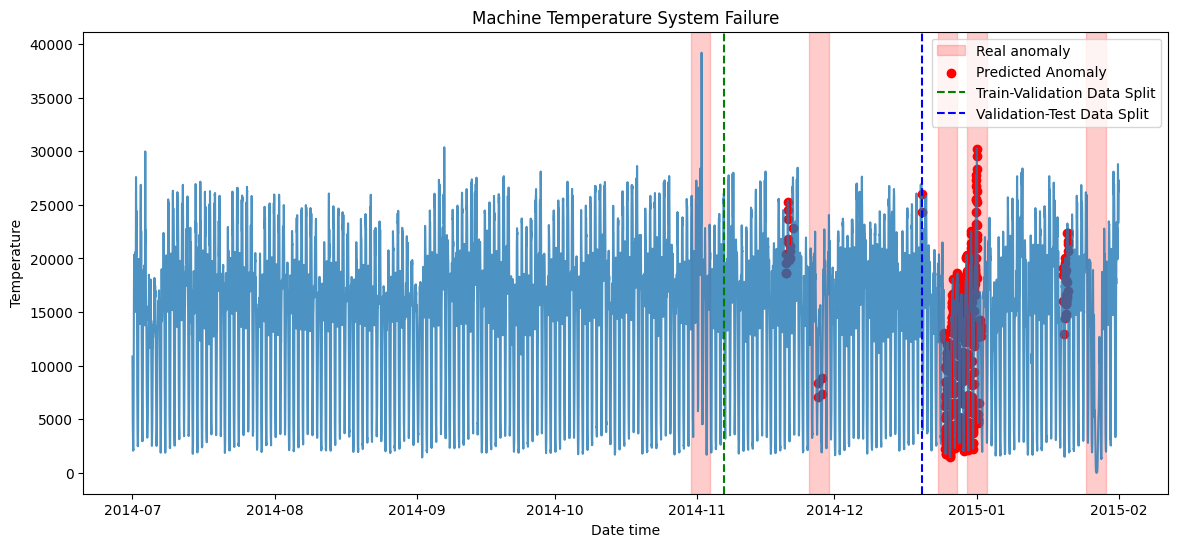

In [314]:
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(data['timestamp'], data['value'], alpha= 0.8)
ax.fill_between(data['timestamp'], 0, 1, where=data['anomaly'], color='red', alpha=0.2, transform=ax.get_xaxis_transform(),label='Real anomaly')
ax.scatter(data_val['timestamp'][val_point_predictions == 1], data_val['value'][val_point_predictions == 1], color='red', label='Predicted Anomaly')
ax.scatter(data_test['timestamp'][test_point_predictions == 1], data_test['value'][test_point_predictions == 1], color='red')
plt.title('Machine Temperature System Failure')
plt.xlabel('Date time')
plt.ylabel('Temperature')
ax.axvline(data_val['timestamp'].iloc[0], color='green', linestyle='--', label='Train-Validation Data Split')
ax.axvline(data_val['timestamp'].iloc[-1], color='blue', linestyle='--', label='Validation-Test Data Split')
plt.legend()
plt.show()